# Определение стоимости автомобилей

# Описание проекта

Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В вашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Вам нужно построить модель для определения стоимости. 

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.

# Описание данных

**Признаки**
- `DateCrawled` — дата скачивания анкеты из базы
- `VehicleType` — тип автомобильного кузова
- `RegistrationYear` — год регистрации автомобиля
- `Gearbox` — тип коробки передач
- `Power` — мощность (л. с.)
- `Model` — модель автомобиля
- `Kilometer` — пробег (км)
- `RegistrationMonth` — месяц регистрации автомобиля
- `FuelType` — тип топлива
- `Brand` — марка автомобиля
- `Repaired` — была машина в ремонте или нет
- `DateCreated` — дата создания анкеты
- `NumberOfPictures` — количество фотографий автомобиля
- `PostalCode` — почтовый индекс владельца анкеты (пользователя)
- `LastSeen` — дата последней активности пользователя

**Целевой признак**
- `Price` — цена (евро)


# План работы


1.	Загрузить и изучить данные. Заполнить пропущенные значения и обработать аномалии в столбцах. Если среди признаков имеются неинформативные, удалить их.
2.	Подготовить выборки для обучения моделей.
3.	Обучить разные модели, одна из которых — LightGBM, как минимум одна — не бустинг. Для каждой модели попробовать разные гиперпараметры.
4.	Проанализировать время обучения, время предсказания и качество моделей.


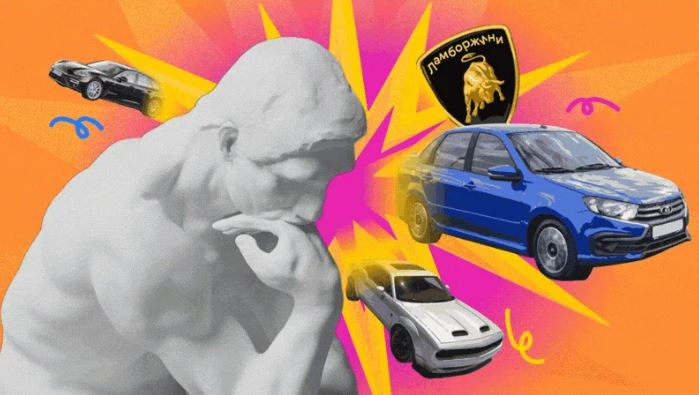

## Подготовка данных

### Импортируем библиотеки

In [1]:
import pandas as pd 
import numpy as np
import os
import time

import matplotlib.pyplot as plt 
import seaborn as sns  

from sklearn.compose import make_column_transformer
from sklearn.preprocessing import OneHotEncoder

from sklearn.model_selection import train_test_split  
from sklearn.preprocessing import OrdinalEncoder

from sklearn.metrics import mean_squared_error, mean_absolute_error, make_scorer 
from sklearn.model_selection import GridSearchCV

from sklearn.linear_model import LinearRegression
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor, cv, Pool

from sklearn.dummy import DummyRegressor

state = 64

### Изучим данные из csv-файла
#### Считаем данные из csv-файлов в датафреймы и сохраним в переменные

In [2]:
pth1 = '/datasets/autos.csv'
pth2 = 'C:\\Users\\Natalia\\Desktop\\Yandex_Projects\\Project_M3_S2\\autos.csv'

if os.path.exists(pth1):
    df = pd.read_csv(pth1)
elif os.path.exists(pth2):
    df = pd.read_csv(pth2)
else:
    print('Something is wrong')

#### Ознакомимся с информацией о датафрейме

In [3]:
display(df.head())
df.sample(5)

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
135383,2016-03-20 17:56:27,4000,wagon,2001,manual,115,passat,150000,3,NaN,volkswagen,no,2016-03-20 00:00:00,0,14776,2016-04-07 00:46:34
67438,2016-03-25 12:37:11,0,sedan,1997,manual,125,a3,150000,6,petrol,audi,no,2016-03-25 00:00:00,0,12459,2016-03-26 22:16:22
5368,2016-03-29 10:49:59,2400,wagon,2002,manual,101,golf,150000,3,gasoline,volkswagen,no,2016-03-29 00:00:00,0,24589,2016-03-31 03:15:46
239782,2016-03-07 13:49:27,15900,wagon,2009,auto,235,5er,125000,9,gasoline,bmw,no,2016-03-07 00:00:00,0,66663,2016-03-17 11:47:31
204232,2016-03-26 08:37:14,15000,wagon,2006,auto,225,a6,150000,3,gasoline,audi,no,2016-03-26 00:00:00,0,63069,2016-03-31 03:44:26


In [4]:
df.info() 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  Repaired           283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

**Проверим пропущенные значения в датасете** 

In [5]:
df.isna().sum()

DateCrawled              0
Price                    0
VehicleType          37490
RegistrationYear         0
Gearbox              19833
Power                    0
Model                19705
Kilometer                0
RegistrationMonth        0
FuelType             32895
Brand                    0
Repaired             71154
DateCreated              0
NumberOfPictures         0
PostalCode               0
LastSeen                 0
dtype: int64

- Данные предоставлены в csv-файле. В датсете 16 колонок по 354369 строк. 
- Имеются пропущенные значения в 5 столбцах: VehicleType, Gearbox, Model, FuelType, Repaired. Это достаточно болшое количество пропусков, необходимо изучить их и заполнить. 

#### Построим общую гистограмму для всех числовых столбцов таблицы

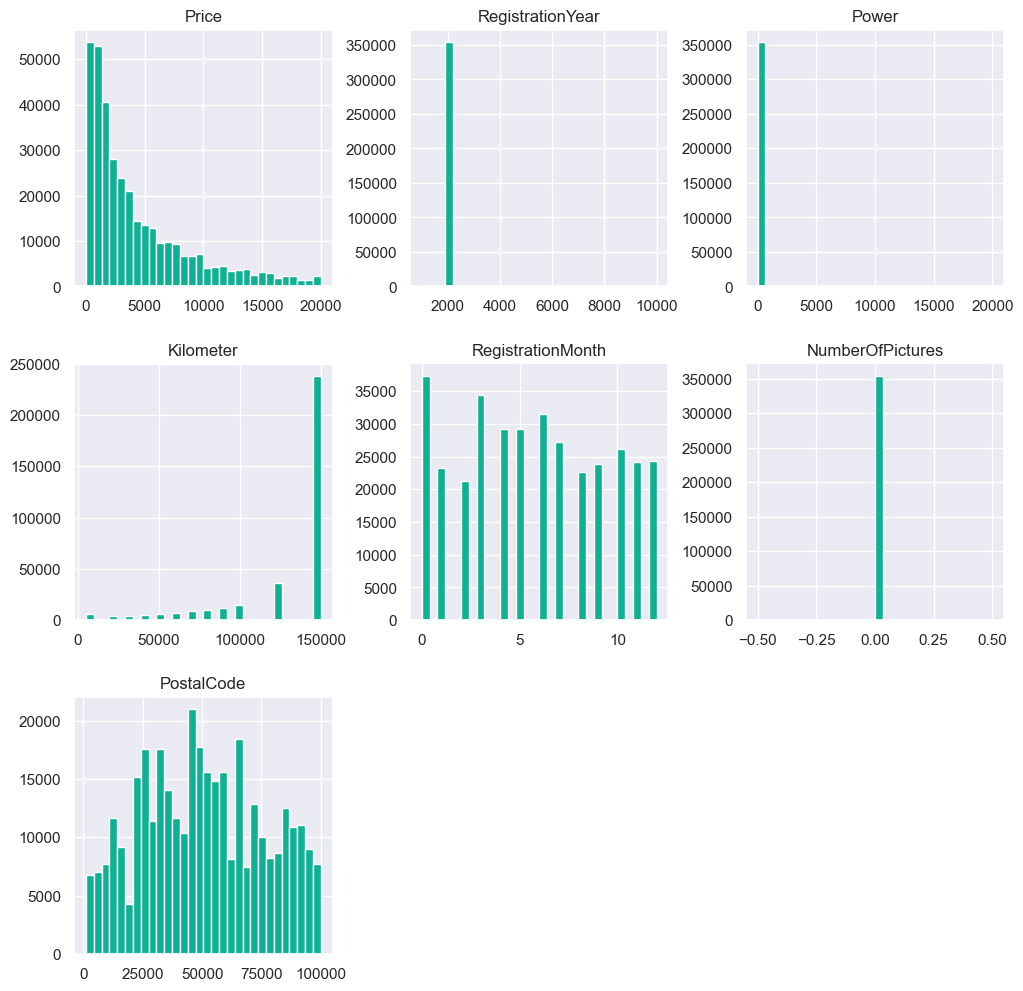

In [6]:
sns.set(style="darkgrid") # set a grey background 
df.hist(bins=30, figsize=(12, 12), color=('#0eb194'))
None

- Гистограммы нескольких числовых столбцов Price и Kilometr показвают распределение Пуассона со сдвигом влево и вправо соотвественно. 
- Гистограмма столбца NumberOfPictures показывает одно значение, равное нулю, следовательно aотографий в данной выгрузке нет. 
- Гистограмм RegistrationYear и Power также показывают одно значение, что странно. Необходимо будет изучить подробнее эти столбцы в ходе предобработки даннх. 

### Предобработка данных

#### Проверим и удалим дубликаты

Проверку дубликатов проведем до удаления стоблцов, не влияющих на обучение модели, поскольку некоторые анкеты разнх пользователей могут совпадать.  

In [7]:
print('Количество полных дубликатов в датасете', df.duplicated().sum())
print(round(df.duplicated().sum()/len(df)*100), '%')

Количество полных дубликатов в датасете 4
0 %


Обнаружено 4 полнх дубликата, это мизерное количество, не влияющее на анализ и обучение модели, потому избавимся от них. 

In [8]:
df = df.drop_duplicates()
print('Количство дубликатов в датасете:', df.duplicated().sum())

Количство дубликатов в датасете: 0


#### Удалим столбцы, не влияющие на анализ и обучение модели  
Гистограмма столбца `NumberOfPictures` показывает одно значение, равное нулю, следовательно фотографий в данной выгрузке нет.

Проверим, есть ли другие значения в столбце: 

In [9]:
df['NumberOfPictures'].value_counts()

0    354365
Name: NumberOfPictures, dtype: int64

**Удалим следующие столбцы:** 
- `NumberOfPictures` (количество фотографй), поскольку все значения равны нулю; 
- `PostalCode` (почтовый индекс владельца анкеты (пользователя)), поскольку мы не делаем индивидуальные предсказания для каждого пользователя, и эти данне нам не потребуются для анализа данных и обучения моделей. 
- `DateCrawled` (дата скачивания анкеты из базы), `DateCreated` (дата создания анкеты), `LastSeen` (дата последней активности пользователя). Эта информация об оберациях с анкетами и активности пользователя, которая не имеет отношения к характеритикам автомобилей, а значит не влияет на цену.  	
- `RegistrationMonth` (месяц регистрации) - не вляиет на цену, поскольку при покупке смотрят на год регистрации. 

In [10]:
df = df.drop(['NumberOfPictures', 'PostalCode', 'DateCrawled', 'DateCreated', 'LastSeen', 'RegistrationMonth'], axis=1)

In [11]:
df.head(20)

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,FuelType,Brand,Repaired
0,480,NaN,1993,manual,0,golf,150000,petrol,volkswagen,NaN
1,18300,coupe,2011,manual,190,NaN,125000,gasoline,audi,yes
2,9800,suv,2004,auto,163,grand,125000,gasoline,jeep,NaN
3,1500,small,2001,manual,75,golf,150000,petrol,volkswagen,no
4,3600,small,2008,manual,69,fabia,90000,gasoline,skoda,no
5,650,sedan,1995,manual,102,3er,150000,petrol,bmw,yes
6,2200,convertible,2004,manual,109,2_reihe,150000,petrol,peugeot,no
7,0,sedan,1980,manual,50,other,40000,petrol,volkswagen,no
8,14500,bus,2014,manual,125,c_max,30000,petrol,ford,NaN
9,999,small,1998,manual,101,golf,150000,NaN,volkswagen,NaN


#### Обработаем пропуски 

Выведем общее количество пропусков датасета 

In [12]:
# Найдем все пропущенные значения в датасете 
print('Количество пропущеннх значений')
print(df.isna().sum())
print()
# Найдем все пропущенные значения в датасете в процентах от общего количества строк 
print('Количество пропущеннх значений в %')
print(round(df.isna().sum()/len(df)*100))

Количество пропущеннх значений
Price                   0
VehicleType         37490
RegistrationYear        0
Gearbox             19833
Power                   0
Model               19705
Kilometer               0
FuelType            32895
Brand                   0
Repaired            71154
dtype: int64

Количество пропущеннх значений в %
Price                0.0
VehicleType         11.0
RegistrationYear     0.0
Gearbox              6.0
Power                0.0
Model                6.0
Kilometer            0.0
FuelType             9.0
Brand                0.0
Repaired            20.0
dtype: float64


Пропуски в 5 нечисловых столбцах:
- VehicleType (тип автомобильного кузова) 11%, 
- Gearbox (тип коробки передач) 6%, 
- Model (модель автомобиля)  6%, 
- FuelType (тип топлива) 9%, 
- Repaired (была машина в ремонте или нет) 20%. 

Наиболее вероятная причина появления пропусков - данные не были введены во время заполнения анкеты. 

Поскльку количество пропусков превышает 5%, м не будем их удалять, чтобы не терять значительную часть датасета. 
Заполним их заглушками: заменим пропуски в столбцах на значение unknown. 


In [13]:
for i in ['VehicleType','Gearbox', 'Model', 'FuelType', 'Repaired']: 
    df[i] = df[i].fillna('unknown')
print('Общее количество пропусков после установки заглушек:')
print(df.isna().sum())

Общее количество пропусков после установки заглушек:
Price               0
VehicleType         0
RegistrationYear    0
Gearbox             0
Power               0
Model               0
Kilometer           0
FuelType            0
Brand               0
Repaired            0
dtype: int64


#### Изучим и обработаем вбросы 

In [14]:
round(df.describe())

,Price,RegistrationYear,Power,Kilometer
count,354365.0,354365.0,354365.0,354365.0
mean,4417.0,2004.0,110.0,128211.0
std,4514.0,90.0,190.0,37905.0
min,0.0,1000.0,0.0,5000.0
25%,1050.0,1999.0,69.0,125000.0
50%,2700.0,2003.0,105.0,150000.0
75%,6400.0,2008.0,143.0,150000.0
max,20000.0,9999.0,20000.0,150000.0


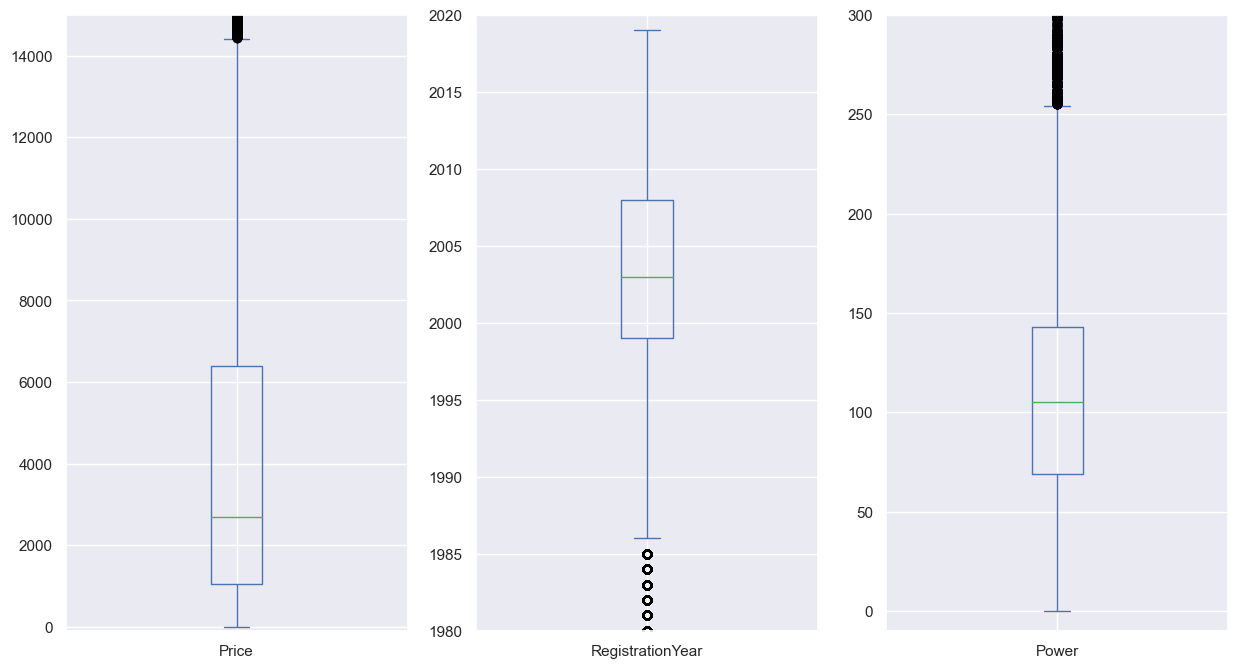

In [15]:
area = ['Price', 'RegistrationYear', 'Power']
boxes = df[area].plot(kind='box', subplots=True, figsize=(15, 8)) 
ylims_min = [-100, 1980, -10]
ylims_max = [15000, 2020, 300]
for i in range(len(area)):
    boxes[area[i]].set_ylim(ylims_min[i], ylims_max[i])

В размах «усов» диаграмм размаха попадают нормальные значения, а за пределами находятся выбросы, изображённые точками.

**Проанаизируем каждый столбец по отдельности.**

- **Столбец `RegistrationYear`** — год регистрации автомобиля. Верхние значения можем ограничить 2016 годом (согласно столбцу `DateCrawled` - дата скачивания анкеты из базы), а нижние значения установим по количеству машин больше 1000 (это 1989 год) - в районе нижнего уса диаграммы размаха.   


In [16]:
df = df.query('1989<= RegistrationYear <=2016')

- **Столбец `Price`** — цена (евро). 

Верхние значения отрезать не будем, поскольку туда могут попадать автомобили элитных категорий, которых всегда очень мало. 
Нижние значения ограничим 100 евро, поскольку значения ниже вглядят нереалистично.  



In [17]:
df = df.query('100<= Price')

- **Столбец `Power`** — мощность (л. с.).
На сегодняшний день самым мощным легковым автомобилем в мире назван Dagger GT компании TranStar Racing LLC,  мощность его двигателя превышает составляет 2028 л. с.). Следовательно, значения выше будем считать выбросами.
Нижнюю границу установим по советскому учебнику, который сообщает:  "Мощность современных (1968) карбюраторных ПДВС легковых автомобилей 20—425 л. с.". Предположим, что в нашем датасете есть древние автомобили с минимальной мощностью 20 л.с.


In [18]:
df = df.query('20<=Power <= 2028')

**Посмотрим, как изменился датасет после удаления выбросов**

In [19]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 289507 entries, 1 to 354368
Data columns (total 10 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   Price             289507 non-null  int64 
 1   VehicleType       289507 non-null  object
 2   RegistrationYear  289507 non-null  int64 
 3   Gearbox           289507 non-null  object
 4   Power             289507 non-null  int64 
 5   Model             289507 non-null  object
 6   Kilometer         289507 non-null  int64 
 7   FuelType          289507 non-null  object
 8   Brand             289507 non-null  object
 9   Repaired          289507 non-null  object
dtypes: int64(4), object(6)
memory usage: 24.3+ MB


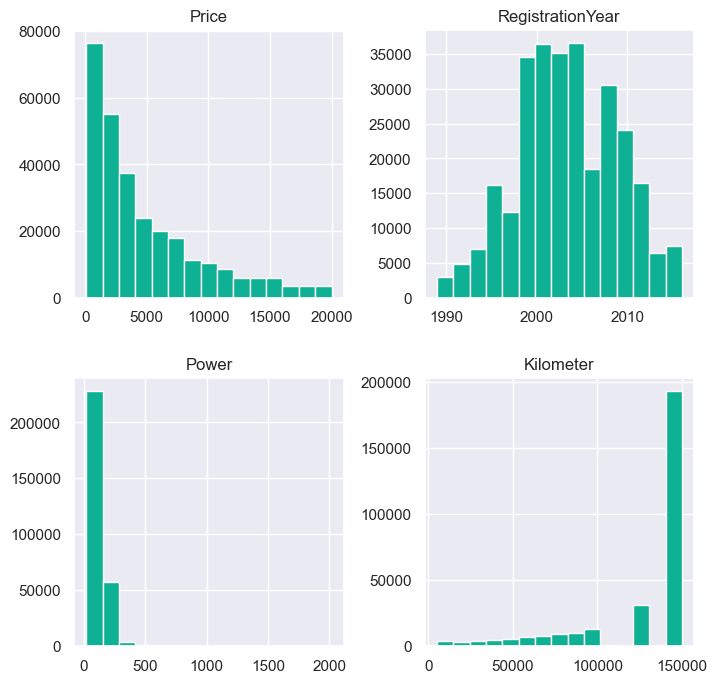

In [20]:
df.hist(bins=15, figsize=(8, 8), color='#0eb194')
None

Гистограмма Года регистрации и Мощности стали более информативнымми, аномалии в столбцах устранены. 

**Рассчитаем, сколько процентов от исходного датасета осталось после удаления выбросов:** 

In [21]:
print('После удаления выбросов осталось', round(len(df)/354369*100), '% от исходного датасета')

После удаления выбросов осталось 82 % от исходного датасета


Датасет значительно сократился, но нам важна чистота данных для качественного обучения модели. 

#### Исследуем корреляцию

In [22]:
df.corr()

,Price,RegistrationYear,Power,Kilometer
Price,1.000000,0.609319,0.426206,-0.394749
RegistrationYear,0.609319,1.000000,0.108286,-0.406687
Power,0.426206,0.108286,1.000000,0.081943
Kilometer,-0.394749,-0.406687,0.081943,1.000000


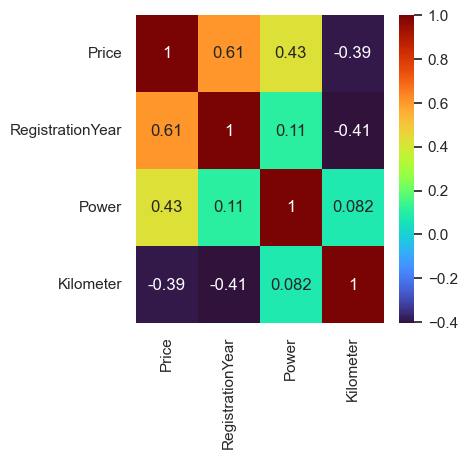

In [23]:
plt.figure(figsize=(4,4))
sns.heatmap(df.corr(), cmap='turbo', annot=True)
None

Для комментариев корреляции воспользуемся  [табличкой](https://statpsy.ru/correlation/velicina/).

Определена корреляция: 
- средняя Между Ценой и годом регистрации (0.61),
- слабая между Ценой и Мощностью (0.43),
- слабая обратная между Ценой и Пробегом (-0.39), а также между Пробегом и Годом регистрации (-0.41).

Кореляция между остальными признаками практически отстутствует (наблюдается очень слабая положительная и отрицательная кореляция), ее не стоит принимать во внимание.

**ВЫВОД** 

**Данные изучены, проведена предобработка данных**

- Данные предоставлены в csv-файле. В датсете 16 колонок по 354369 строк.
- Обнаружено и удалено 4 полнх дубликата.
- Удалены следующие столбцы:
 - NumberOfPictures (количество фотографй), поскольку все значения равны нулю;
 - PostalCode (почтовый индекс владельца анкеты (пользователя)), поскольку мы не делаем индивидуальные предсказания для каждого пользователя, и эти данне нам не потребуются для анализа данных и обучения моделей.
 - DateCrawled (дата скачивания анкеты из базы), DateCreated (дата создания анкеты), LastSeen (дата последней активности пользователя). Эта информация об оберациях с анкетами и активности пользователя, которая не имеет отношения к характеритикам автомобилей, а значит не влияет на цену.
 - RegistrationMonth (месяц регистрации) - не вляиет на цену, поскольку при покупке смотрят на год регистрации.

- Пропуски в 5 нечисловых столбцах заполнены заглушками unknown:
 - VehicleType (тип автомобильного кузова) 11%,
 - Gearbox (тип коробки передач) 6%,
 - Model (модель автомобиля) 6%,
 - FuelType (тип топлива) 9%,
 - Repaired (была машина в ремонте или нет) 20%.
Наиболее вероятная причина появления пропусков - данные не были введены во время заполнения анкеты.

- Определены и удалены выбросы в числовых столбцах  RegistrationYear, Price,  Power. После удаления выбросов осталось 82 % от исходного датасета. Датасет значительно сократился, но нам важна чистота данных для качественного обучения модели.

- Определена корреляция: 
 - средняя Между Ценой и годом регистрации (0.61),
 - слабая между Ценой и Мощностью (0.43),
 - слабая обратная между Ценой и Пробегом (-0.39), а также между Пробегом и Годом регистрации (-0.41).
 - Кореляция между остальными признаками практически отстутствует (наблюдается очень слабая положительная и отрицательная кореляция), ее не стоит принимать во внимание.

## Обучение моделей

**Обучим разные модели для прогнозирования цены автомобиля: LinearRegression, LGBMRegression и CatBoostRegression.** 

### Подготовим выборки для обучения моделей

#### Создадим переменные для признаков

Создадим из две переменные с признаками и целевым признаком:

- features — признаки. Содержит все столбцы, кроме `Price`.
- target — целевой признак. Сюда запишем данные столбца `Price`.

In [24]:
features = df.drop(['Price'], axis=1)
target = df['Price']
print(features.shape)
print(target.shape)

(289507, 9)
(289507,)


#### Разбивка данных на выборки и кодирование столбцов

Сначала необходимо разбить датасет на выборки, а после провести кодирование столбцов. Работаем именно в таком порядке, чтобы избежать учечек. 

Данные датасета нужно разбить на три части: обучающую, валидационную и тестовую. Размеры тестового и валидационного наборов обычно равны. Исходные данные разбиваем в соотношении 3:1:1.

Разбивку исходного датасета проведем в два этапа:
- Разобьем исходный датасет на обучающую (60%) и остаточную (40%) выборки. 
- Остаточную далее разобьем пополам на тестовую и валидационную. 

**Отложим тестовую выборку до конца работы (представим, что она где-то спрятана уклиента), чтобы протестировать на ней одну лучшую модель в конце**. Обучать будем на тренировочной и проверять предсказания на валидационной. Затем выберем лучшую модель. 

Напишем функцию для разбиния датасета на обучающую, валидационную и тестовую выборки, чтобы в дальнейшем создать необходиме вборки с кодированием столбцов и без. 



In [25]:
features_train, features_delta, target_train, target_delta = train_test_split(features, target, 
                                                                              test_size=0.4, 
                                                                              random_state=state)

features_valid, features_test, target_valid, target_test = train_test_split(features_delta, target_delta, 
                                                                              test_size=0.5, 
                                                                              random_state=state)

print('Обучающая выборка - признаки', features_train.shape)
print('Обучающая выборка - целевой признак', target_train.shape)
print('Валидационная выборка - признаки', features_valid.shape)
print('Тестовая выборка - признаки', features_test.shape)
print('Валидационная выборка - целевой признак', target_valid.shape)
print('Тестовая выборка - целевой признак', target_test.shape)

Обучающая выборка - признаки (173704, 9)
Обучающая выборка - целевой признак (173704,)
Валидационная выборка - признаки (57901, 9)
Тестовая выборка - признаки (57902, 9)
Валидационная выборка - целевой признак (57901,)
Тестовая выборка - целевой признак (57902,)


#### Кодирование столбцов

- **Кодируем данные для работы с LinearRegression.** 
Закодируем нечисловые столбцы с категориальными значениями `VehicleType`, `Gearbox`, `Model`, `FuelType`, `Brand`, `Repaired`. 
Используем прямое кодирование (OHE), поскольку оно подходит для работы со всеми моделями, в то время как порядковое кодирование не подходит для работы с линейной регрессией. 

In [26]:
cat_columns = ['VehicleType', 'Gearbox', 'Model', 'FuelType', 'Brand', 'Repaired']
enc = OneHotEncoder(handle_unknown='ignore', sparse=False)
features_train_ohe = pd.DataFrame(enc.fit_transform(features_train[cat_columns]))
features_valid_ohe = enc.transform(features_valid[cat_columns])
features_test_ohe = enc.transform(features_test[cat_columns])

features_train_ohe.shape, features_valid_ohe.shape, features_test_ohe.shape

((173704, 311), (57901, 311), (57902, 311))

- **Кодируем данне для раоты с LGBMRegression**. Модели градиентного бустинга не требуют OHE кодирование категориальных признаков, но могут возникнуть пролем с типом object. Используем в данном случае порядковое кодирование Ordinal Encoding, чтобы закодировать цифрами выраженные в тексте категории. 



In [27]:
def oe_transform(df):
    encoder = OrdinalEncoder() 
    df_oe = pd.DataFrame(encoder.fit_transform(df), columns=features_train.columns)
    return df_oe

In [28]:
features_train_oe = oe_transform(features_train)
features_valid_oe = oe_transform(features_valid)
features_test_oe = oe_transform(features_test)

features_train_oe.shape, features_valid_oe.shape, features_test_oe.shape

((173704, 9), (57901, 9), (57902, 9))

- **Для работы с CatBoostRegression меняем категорию столбцов**. 

CatBoost имеет встроеннй кодировщий, потому для данной модели мы будем использовать кодирование, но изменим `object` на `category`. 

In [29]:
cat_features = ['VehicleType', 'Gearbox', 'Model', 'FuelType', 'Brand', 'Repaired']

for col in cat_features:
    features_train[col] = features_train[col].astype('category')
    features_valid[col] = features_valid[col].astype('category')
    features_test[col] = features_test[col].astype('category')

features_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 173704 entries, 1570 to 106462
Data columns (total 9 columns):
 #   Column            Non-Null Count   Dtype   
---  ------            --------------   -----   
 0   VehicleType       173704 non-null  category
 1   RegistrationYear  173704 non-null  int64   
 2   Gearbox           173704 non-null  category
 3   Power             173704 non-null  int64   
 4   Model             173704 non-null  category
 5   Kilometer         173704 non-null  int64   
 6   FuelType          173704 non-null  category
 7   Brand             173704 non-null  category
 8   Repaired          173704 non-null  category
dtypes: category(6), int64(3)
memory usage: 6.5 MB


### Создадим и обучим модели 

Напишем функцию расчета RMSE, которую будем использовать в дальнейшем для оценки качества модели

In [30]:
def rmse_calc(target, predict):
    return np.sqrt(mean_squared_error(target, predict))


Для оценки моделей создадим метрику с помощью make_scorer:

In [31]:
rmse_scorer = make_scorer(rmse_calc, greater_is_better = False)

Создадим функцию, чтобы проанализировать время обучения, время предсказания и качество моделей, а также для поиска наилучших параметров моделей с помощью кроссвалидации в составе GridSearchCV.

In [32]:
def time_quality_calc(model, params, features_train, target_train, features_test, target_test):
    
    grid_search = GridSearchCV(model,
                      param_grid=params,
                      cv = 5,
                      scoring = rmse_scorer,
                      n_jobs = -1,  
                      verbose=10)
    
    start = time.time()    
    grid_search.fit(features_train, target_train)
    time_train = time.time() - start
   
    start = time.time()  
    target_pred = grid_search.predict(features_test)
    time_predict = time.time() - start
 
    best_params = grid_search.best_params_
    
    rmse = np.sqrt(mean_squared_error(target_test, target_pred))

    return time_train, time_predict, rmse, best_params

Обозначим гиперпараметры, которые будут перебираться в grid_search:

In [33]:
param_grid_lr = {}

param_grid_lgbm =  {'max_depth':range (5, 30),
                    "learning_rate":[0.1, 0.3], 
                    'n_estimators': range (5, 65, 10)}

param_grid_cat = {'iterations': [10, 50],
          'depth': [5, 10, 15],
          'learning_rate': [0.1, 0.3]}

param_grid_dr = {}

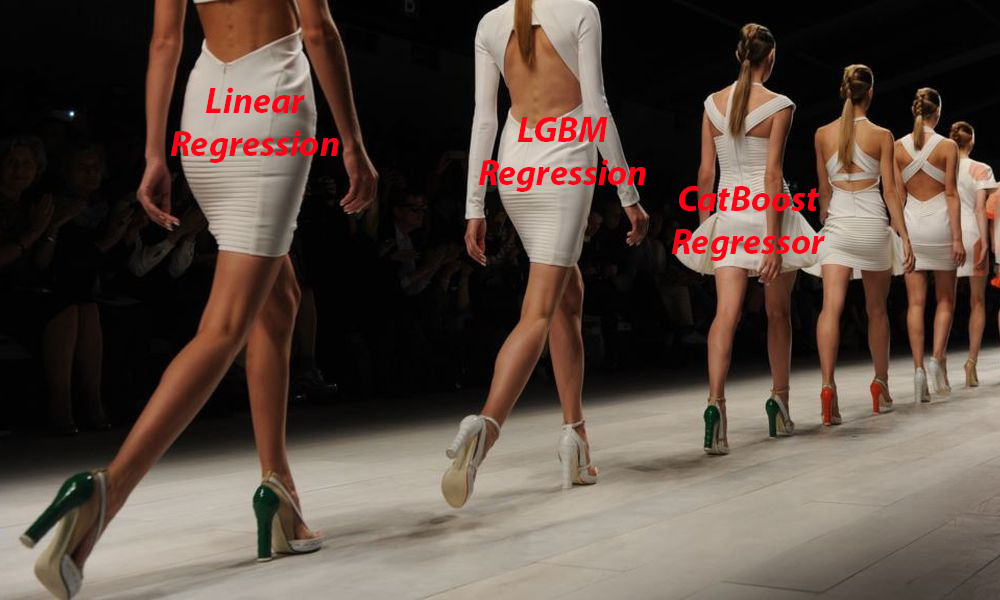

#### LinearRegression

Будем использовать данные, закодированные с помощью OHE. 
Обучим на тренировочной выборке, предсказания сделаем на валидационной выборке. 




In [34]:
time_train_lr, time_predict_lr, rmse_lr, best_params_lr = time_quality_calc(LinearRegression(), 
                                                                          param_grid_lr,
                                                                          features_train_ohe, 
                                                                               target_train,
                                                                              features_valid_ohe, 
                                                                                target_valid)

print('Время обучения: ', round(time_train_lr, 3), 'sec')
print('Время предсказания: ', round(time_predict_lr, 4), 'sec')
print('RMSE модели: ', round(rmse_lr))

Fitting 5 folds for each of 1 candidates, totalling 5 fits
Время обучения:  326.172 sec
Время предсказания:  0.1279 sec
RMSE модели:  3541


#### LGBMRegression 

Будем использоваь данные, закодированные с помощью OrdinalEncoder. Обучим на тренировочной выборке, предсказания сделаем на валидационной выборке.

Чтобы оценить гиперпараметры модели, используем GridSearchCV на данных обучающей выборки. GridSearchCV уже включает в себя кросс-валидацию.

Напишем функцию расчета RMSE, и на ее основе для оценки моделей создадим метрику с помощью make_scorer:

In [35]:
time_train_lgbm, time_predict_lgbm, rmse_lgbm, best_params_lgbm = time_quality_calc(LGBMRegressor(),
                                                                  param_grid_lgbm,
                                                                  features_train_oe, 
                                                                               target_train,
                                                                              features_valid_oe, 
                                                                                target_valid)

print('Параметр лучшей модели:', best_params_lgbm)
print('Время обучения: ', round(time_train_lgbm/60, 3), 'minutes')
print('Время предсказания: ', round(time_predict_lgbm, 4), 'sec')
print('RMSE модели: ', round(rmse_lgbm))

Fitting 5 folds for each of 300 candidates, totalling 1500 fits
Параметр лучшей модели: {'learning_rate': 0.3, 'max_depth': 12, 'n_estimators': 55}
Время обучения:  8.543 minutes
Время предсказания:  0.1089 sec
RMSE модели:  1685


#### CatBoostRegressor

Будем использовать незакодированные данные, но с измененной категорией столбцов. 

In [36]:
time_train_cat, time_predict_cat, rmse_cat, best_params_cat = time_quality_calc(CatBoostRegressor(loss_function='RMSE', 
                                                                                                silent=True, 
                                                                                                cat_features=cat_features),
                                                                              param_grid_cat,
                                                                              features_train, 
                                                                              target_train,
                                                                              features_valid, 
                                                                              target_valid)


print('Параметр лучшей модели:', best_params_cat)
print('Время обучения: ', round(time_train_cat/60, 3), 'minutes')
print('Время предсказания: ', round(time_predict_cat, 4), 'sec')
print('RMSE модели: ', round(np.abs(rmse_cat)))

Fitting 5 folds for each of 12 candidates, totalling 60 fits
Параметр лучшей модели: {'depth': 15, 'iterations': 50, 'learning_rate': 0.3}
Время обучения:  9.153 minutes
Время предсказания:  0.077 sec
RMSE модели:  1505


**ВВОД:** 
1. Подготовлены выборки для обучения моделей
- Созданы переменные для признаков
- Проведена разбивка данных на выборки в соотношении 3:1:1 - обучающая, валидационная и тестовая соответственно. 
- проведено кодирование столбцов с категориальными значениями VehicleType, Gearbox, Model, FuelType, Brand, Repaired. 
 - Используем прямое кодирование (OHE) для работы с LinearRegression.
 - Используем порядковое кодирование Ordinal Encoding для раоты с LGBMRegression. 
 - Для работы с CatBoostRegression меняем категорию столбцов (изменили object на category).
 
2. Обучены и провалидированы разные модели для прогнозирования цены автомобиля: LinearRegression, LGBMRegression и CatBoostRegression.
- Написана функция для подсчета RMSE, и создана метрика для оценки качества моделей с помощью make_corer.
- Подбор параметров осущкствлен с помощью CgidSearchCV. 
- Обучение моделей проведено на обучающей выборке, а предсказания и оценка RMSE на валидационной. 


## Анализ моделей

### Сравнение полученнх результатов 

Соберем в общую таблицу значения RMSE, время обучения и предсказания в секундах. 



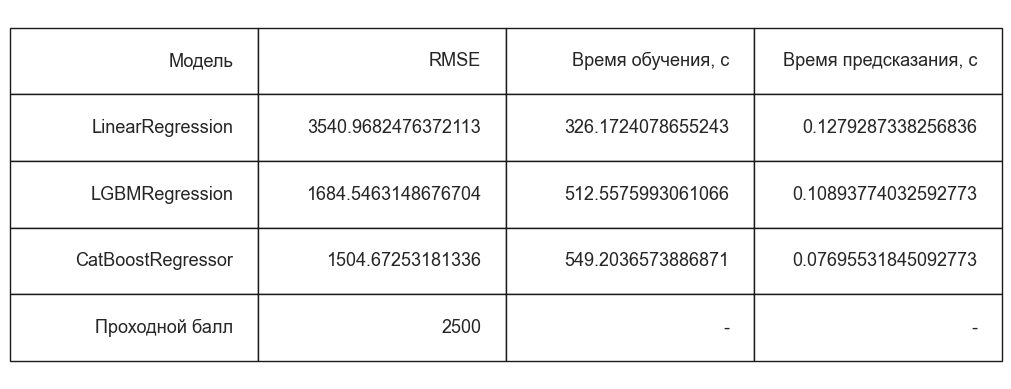

In [37]:
#define figure and axes
fig, ax = plt.subplots()

#create values for table
table_data=[
 ["Модель", "RMSE", "Время обучения, c", "Время предсказания, с"],
 ["LinearRegression", rmse_lr, time_train_lr, time_predict_lr],
 ["LGBMRegression", rmse_lgbm, time_train_lgbm, time_predict_lgbm],
 ["CatBoostRegressor", rmse_cat, time_train_cat, time_predict_cat],
 ["Проходной балл", "2500", "-", "-"],
]

#create table
table = ax.table (cellText=table_data, loc='center')

#modify table
table.set_fontsize (14)
table. scale (2,4)
ax.axis('off')

#display table
plt.show() 

- **LinearRegression не прошла проверку** по значению RMSE = 3540, что выше проходного значения RMSE = 2500 (требование проекта). Хотя по скорости обучения она на втором месте, и по скорости предсказания на первом, дальнейшая работа с ней не имеет смысла. 
- **CatBoostRegressor - лучшая модель** по результатам проверки на валидационной выборке. Имеет самое низкое значение RMSE = 1504 и скорость обучения, на втором месте по скорости предсказания. 
- **LGBMRegression** - на втором месте по значению RMSE = 1684, на третьем по скорости обучения и предсказания.

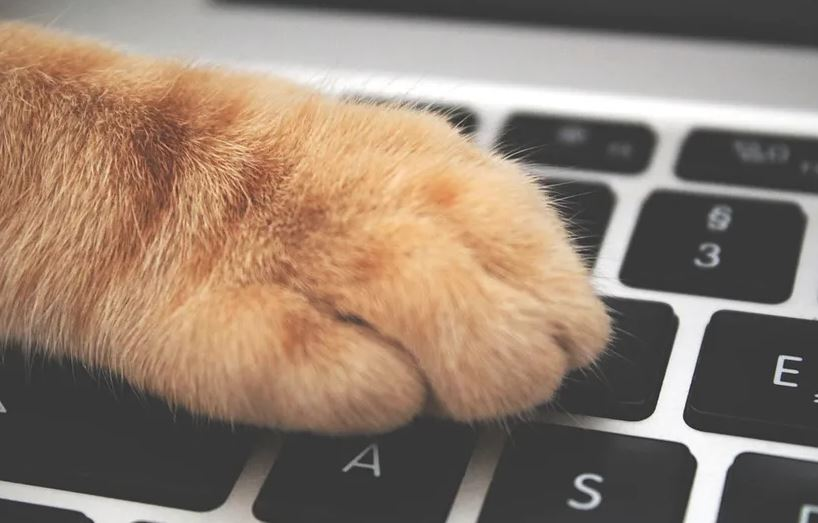

### Проверка моделей на адекватность  

**Обучим на тренировойчной выборке и протестируем на тесте DummyRegressor**, в качестве параметра используем медиану. 
Затем сравним результаты, которые выдает дамми модель с результатами, полученными нами для моделей выше. 

In [38]:
time_train_dr, time_predict_dr, rmse_dr, best_params_dr = time_quality_calc(DummyRegressor(strategy = 'median'), 
                                                                          param_grid_dr,
                                                                          features_train_ohe, 
                                                                               target_train,
                                                                              features_test_ohe, 
                                                                                target_test)

print('Время обучения: ', round(time_train_dr, 3), 'sec')
print('Время предсказания: ', round(time_predict_dr, 5), 'sec')
print('RMSE модели: ', round(rmse_dr))

Fitting 5 folds for each of 1 candidates, totalling 5 fits
Время обучения:  6.312 sec
Время предсказания:  0.001 sec
RMSE модели:  4925


DummyRegressor показал худшее значение RMSE = 4925, что не удивительно. 
Все модели данного проекта прошли проверку на адевватность, поскольку значения их метрик RMSE гораздо ниже. 

### Тестирование лучшей модели 

Обучим лучшую модель - CatBoostRegressor с лучшими параметрами, подобранными с помощью грид серча. 

In [39]:
%%time 
best_model = CatBoostRegressor(loss_function='RMSE', 
                               silent=True,
                               cat_features=cat_features, 
                               depth = 15, 
                               iterations= 50, 
                               learning_rate= 0.3).fit(features_train, target_train)

Wall time: 44.2 s


Сделаем предсказания лучшей модели на тестовой выборке: 

In [40]:
%%time 
best_model_predict = best_model.predict(features_test)

Wall time: 110 ms


Рассчитаем RMSE лучшей модели на тестовой выборке: 

In [41]:
%%time 
best_model_rmse = rmse_calc(target_test, best_model_predict)

print('RMSE лучшей модели на тестовой выборке: ', round(best_model_rmse))

RMSE лучшей модели на тестовой выборке:  1525
Wall time: 2 ms


Лучшая модель CatBoostRegressor на тесте показала RMSE = 1525, что ниже требуемого RMSE = 2500. Время оучения модели с лучшими параметрами, заранее подобранными с посощью GridSearchCV, составило 41.6 s, а предсказание заняло 109 ms. 

**ВЫВОД:** 
1. Проведен анализ моделей LinearRegression, LGBMRegression и CatBoostRegression: 
- **LinearRegression не прошла проверку** по значению RMSE = 3540, что выше проходного значения RMSE = 2500 (требование проекта). Хотя по скорости обучения она на втором месте, и по скорости предсказания на первом, дальнейшая работа с ней не имеет смысла. 
- **CatBoostRegressor - лучшая модель** по результатам проверки на валидационной выборке. Имеет самое низкое значение RMSE = 1504 и скорость обучения, на втором месте по скорости предсказания. 
- **LGBMRegression** - на втором месте по значению RMSE = 1684, на третьем по скорости обучения и предсказания.
2. Проведена проверка адеватности моделей
DummyRegressor показал худшее значение RMSE = 4925, что не удивительно. Все модели данного проекта прошли проверку на адевватность, поскольку значения их метрик RMSE гораздо ниже, чем у дамми модели.

**Лучшая модель CatBoostRegressor на тесте показала RMSE = 1525, что ниже требуемого RMSE = 2500. Время оучения модели с лучшими параметрами, заранее подобранными с посощью GridSearchCV, составило 41.6 s, а предсказание заняло 109 ms.**

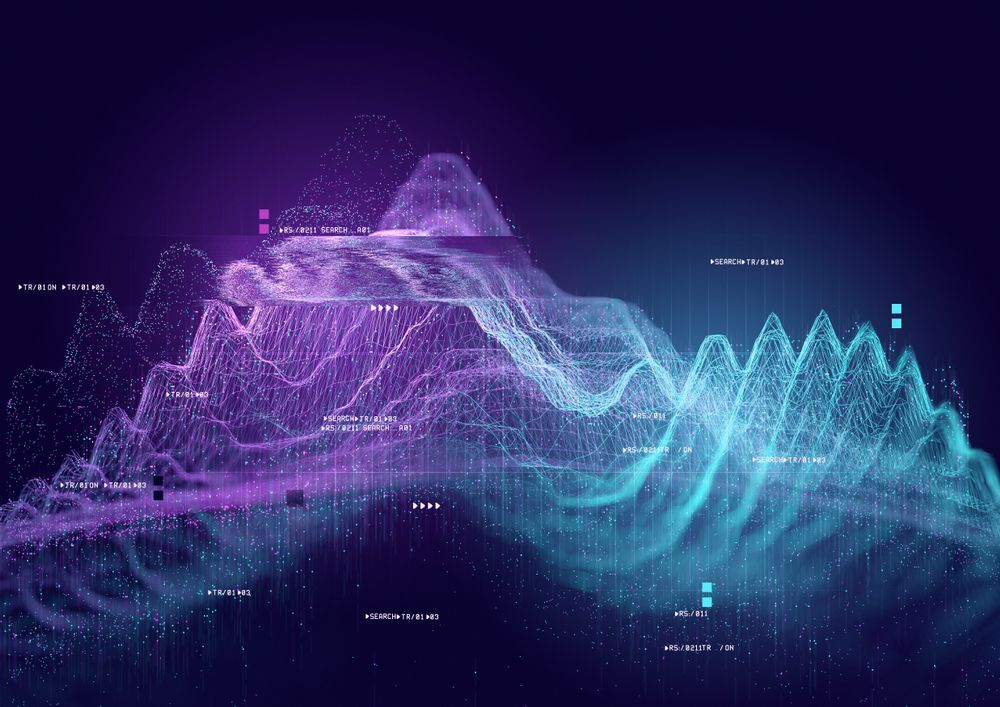

# Общий вывод 

**I. Данные изучены, проведена предобработка данных**

- Данные предоставлены в csv-файле. В датсете 16 колонок по 354369 строк.
- Обнаружено и удалено 4 полнх дубликата.
- Удалены следующие столбцы:
 - NumberOfPictures (количество фотографй), поскольку все значения равны нулю;
 - PostalCode (почтовый индекс владельца анкеты (пользователя)), поскольку мы не делаем индивидуальные предсказания для каждого пользователя, и эти данне нам не потребуются для анализа данных и обучения моделей.
 - DateCrawled (дата скачивания анкеты из базы), DateCreated (дата создания анкеты), LastSeen (дата последней активности пользователя). Эта информация об оберациях с анкетами и активности пользователя, которая не имеет отношения к характеритикам автомобилей, а значит не влияет на цену.
 - RegistrationMonth (месяц регистрации) - не вляиет на цену, поскольку при покупке смотрят на год регистрации.

- Пропуски в 5 нечисловых столбцах заполнены заглушками unknown:
 - VehicleType (тип автомобильного кузова) 11%,
 - Gearbox (тип коробки передач) 6%,
 - Model (модель автомобиля) 6%,
 - FuelType (тип топлива) 9%,
 - Repaired (была машина в ремонте или нет) 20%.
Наиболее вероятная причина появления пропусков - данные не были введены во время заполнения анкеты.

- Определены и удалены выбросы в числовых столбцах  RegistrationYear, Price,  Power. После удаления выбросов осталось 82 % от исходного датасета. Датасет значительно сократился, но нам важна чистота данных для качественного обучения модели.

- Определена корреляция: 
 - средняя Между Ценой и годом регистрации (0.61),
 - слабая между Ценой и Мощностью (0.43),
 - слабая обратная между Ценой и Пробегом (-0.39), а также между Пробегом и Годом регистрации (-0.41).
 - Кореляция между остальными признаками практически отстутствует (наблюдается очень слабая положительная и отрицательная кореляция), ее не стоит принимать во внимание.
 
**II. Обучение моделей**  
- **Подготовлены выборки для обучения моделей**
 - Созданы переменные для признаков
 - Проведена разбивка данных на выборки в соотношении 3:1:1 - обучающая, валидационная и тестовая соответственно. 
 - проведено кодирование столбцов с категориальными значениями VehicleType, Gearbox, Model, FuelType, Brand, Repaired. 
   - Используем прямое кодирование (OHE) для работы с LinearRegression.
   - Используем порядковое кодирование Ordinal Encoding для раоты с LGBMRegression. 
   - Для работы с CatBoostRegression меняем категорию столбцов (изменили object на category).
 
- **Обучены и провалидированы разные модели для прогнозирования цены автомобиля: LinearRegression, LGBMRegression и CatBoostRegression.**
 - Написана функция для подсчета RMSE, и создана метрика для оценки качества моделей с помощью make_corer.
 - Подбор параметров осущкствлен с помощью CgidSearchCV. 
 - Обучение моделей проведено на обучающей выборке, а предсказания и оценка RMSE на валидационной. 

**III.Проведен анализ моделей LinearRegression, LGBMRegression и CatBoostRegression:** 
- **LinearRegression не прошла проверку** по значению RMSE = 3540, что выше проходного значения RMSE = 2500 (требование проекта). Хотя по скорости обучения она на втором месте, и по скорости предсказания на первом, дальнейшая работа с ней не имеет смысла. 
- **CatBoostRegressor - лучшая модель** по результатам проверки на валидационной выборке. Имеет самое низкое значение RMSE = 1504 и скорость обучения, на втором месте по скорости предсказания. 
- **LGBMRegression** - на втором месте по значению RMSE = 1684, на третьем по скорости обучения и предсказания.
**Проведена проверка адеватности моделей**
DummyRegressor показал худшее значение RMSE = 4925, что не удивительно. Все модели данного проекта прошли проверку на адевватность, поскольку значения их метрик RMSE гораздо ниже, чем у дамми модели.

# Итоговый вывод

**Лучшая модель CatBoostRegressor на тесте показала RMSE = 1525, что ниже требуемого RMSE = 2500. Время оучения модели с лучшими параметрами, заранее подобранными с посощью GridSearchCV, составило 41.6 s, а предсказание заняло 109 ms.**
